### Capture

This notebook captures frames from the depth camera to analyze it and come up with the best approach to preprocess the image and the depth matrices.

In [14]:
import os
import cv2
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import pandas as pd
import seaborn as sns
import pyrealsense2 as rs
import time
import json
import traceback
import scipy.ndimage as ndimage
from scipy.ndimage import sobel, median_filter
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from skimage.restoration import denoise_wavelet, denoise_bilateral, denoise_nl_means
from skimage.metrics import structural_similarity as ssim

Verifies if the *Intel(R) RealSense(TM) Depth Camera 435* shows up

In [15]:
!lsusb | grep RealSense

Bus 002 Device 005: ID 8086:0b07 Intel Corp. RealSense D435


In [25]:
CAMERA_RESOLUTION = 640, 480, 30

def read_frames(total_frames=120):
    depth_frames = []
    color_frames = []
    pipeline = None
    started = False
    try:
        print("Openning depth camera ...")
        for dev in rs.context().query_devices():
            print(dev)
            dev.hardware_reset()

        pipeline = rs.pipeline()
        config = rs.config()
        config.disable_all_streams()
        config.enable_stream(rs.stream.depth, CAMERA_RESOLUTION[0], CAMERA_RESOLUTION[1], rs.format.z16, CAMERA_RESOLUTION[2])
        config.enable_stream(rs.stream.color, CAMERA_RESOLUTION[0], CAMERA_RESOLUTION[1], rs.format.bgr8, CAMERA_RESOLUTION[2])

        profile = pipeline.start(config)
        started = True
        intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
        align = rs.align(rs.stream.color)

        # skip first 2 seconds of camera captures
        print("Skipping initial frames ...")
        for _ in range(CAMERA_RESOLUTION[2]*2): pipeline.wait_for_frames(timeout_ms=1000)

        print("Capturing frames ...")
        while len(depth_frames) < total_frames:
            frames = pipeline.wait_for_frames(timeout_ms=1000)
            if not frames: continue
                
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame: continue
    
            frames = align.process(frames)
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame: continue
    
            color_frames.append(np.asanyarray(color_frame.get_data()).copy())
            depth_frames.append(np.asanyarray(depth_frame.get_data()).copy())
    except:
        traceback.print_exc()
    finally:
        print("Cleaning resources ...")
        if pipeline is not None and started:
            pipeline.stop()

    return np.array(depth_frames), np.array(color_frames)

def enhance_single_frame(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    enhanced_lab = cv2.merge((l, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

def enhance_multi_frame(images):
    return np.mean(images, axis=0).astype(np.uint8)

def compute_sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def imshow(title:str, image1:np.ndarray, image2:np.ndarray=None, color_map=cv2.COLORMAP_RAINBOW) -> None:
    frame = image1
    if image2 is not None and len(image2.shape) == 2:
        colored = cv2.applyColorMap(cv2.convertScaleAbs(image2, alpha=0.15), color_map)
        frame = np.hstack((image1, colored))
    elif image2 is not None and len(image2.shape) == 3:
        frame = np.hstack((image1, image2))
        
    plt.figure(figsize=(15, 8) if image2 is not None else (7, 4))
    plt.title(title)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Get some sample data

In [17]:
depths, images = read_frames()

Openning depth camera ...
<pyrealsense2.device: D435 (S/N: 213522071086  FW: 5.12.7.150  on USB3.2)>
Skipping initial frames ...
Capturing frames ...
Cleaning resources ...


# Render a random image along with its depth matrix

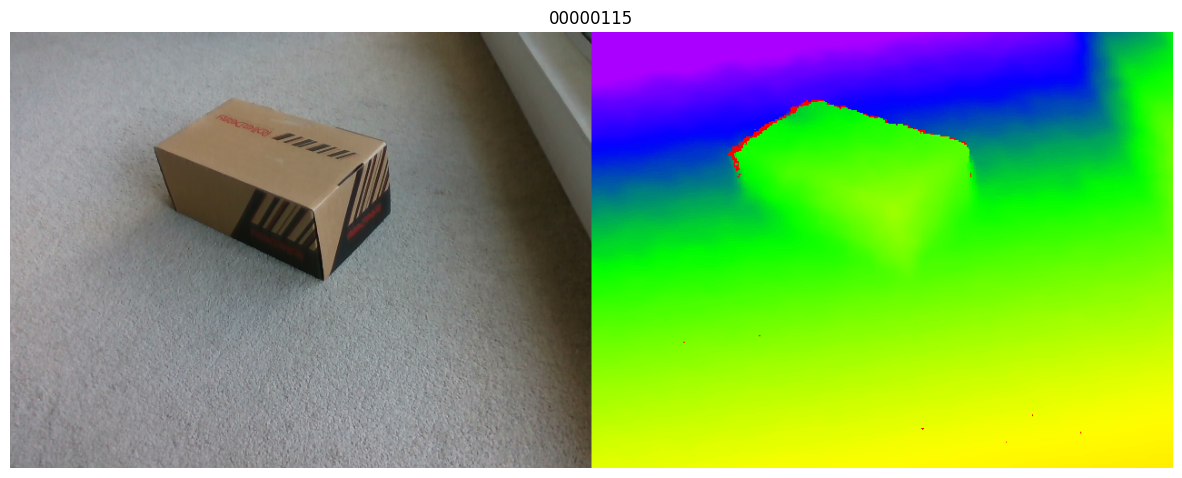

In [18]:
sample_index = rnd.randint(0, len(images))
imshow(f"{sample_index:08}", images[sample_index], depths[sample_index])

# Find the best technique to improve the color frame

In [29]:
single_frame_enhanced = enhance_single_frame(images[-1])
multi_frame_enhanced = enhance_multi_frame(images)

# Compute sharpness
original_sharpness = compute_sharpness(images[-1])
single_frame_sharpness = compute_sharpness(single_frame_enhanced)
multi_frame_sharpness = compute_sharpness(multi_frame_enhanced)

# Determine best method
sharpness_scores = {
    'Original': original_sharpness.round(2),
    'Equalized Frame': single_frame_sharpness.round(2),
    'Mean': multi_frame_sharpness.round(2)
}
best_method = max(sharpness_scores, key=sharpness_scores.get)
print(f'Best enhancement method: {best_method}')
print(sharpness_scores)

Best enhancement method: Equalized Frame
{'Original': np.float64(450.51), 'Equalized Frame': np.float64(5201.69), 'Mean': np.float64(419.11)}


# Find the best denoising technique for the depth matrix

In [30]:
# Basic statistics of the noise
def analyze_noise_statistics(frames):
    mean_frame = np.mean(frames, axis=0)
    std_frame = np.std(frames, axis=0)
    
    # Calculate temporal noise characteristics
    temporal_noise = {}
    temporal_noise['mean_std'] = np.mean(std_frame)
    temporal_noise['max_std'] = np.max(std_frame)
    temporal_noise['std_of_std'] = np.std(std_frame)
    
    # Calculate pixel-wise noise distribution stats
    # Pick a random pixel to analyze
    pixel_x, pixel_y = 50, 50
    pixel_values = frames[:, pixel_x, pixel_y]
    temporal_noise['pixel_std'] = np.std(pixel_values)
    temporal_noise['pixel_skewness'] = skew(pixel_values)
    temporal_noise['pixel_kurtosis'] = kurtosis(pixel_values)
    
    return mean_frame, std_frame, temporal_noise

# Frequency domain analysis
def analyze_frequency_domain(frames):
    # Compute 2D FFT on the mean-subtracted data
    mean_frame = np.mean(frames, axis=0)
    freq_domain_data = []
    
    for frame in frames:
        frame_centered = frame - mean_frame
        frame_fft = np.fft.fft2(frame_centered)
        frame_fft_shifted = np.fft.fftshift(frame_fft)
        freq_domain_data.append(np.abs(frame_fft_shifted))
    
    avg_freq_spectrum = np.mean(freq_domain_data, axis=0)
    return avg_freq_spectrum

# Test different noise reduction techniques
def test_noise_reduction_techniques(frames):
    mean_frame = np.mean(frames, axis=0)
    
    # Technique 1: Simple averaging (mean)
    technique_mean = mean_frame
    
    # Technique 2: Median filtering
    technique_median = np.median(frames, axis=0)
    
    # Technique 3: Gaussian spatial filter on mean
    technique_gaussian = ndimage.gaussian_filter(mean_frame, sigma=1.0)
    
    # Technique 4: Bilateral filter (edge-preserving)
    technique_bilateral = denoise_bilateral(mean_frame, sigma_color=0.1, sigma_spatial=2)
    
    # Technique 5: Temporal median + spatial median
    temp_median = np.median(frames, axis=0)
    technique_temp_spatial = ndimage.median_filter(temp_median, size=3)
    
    # Technique 6: PCA-based denoising
    h, w = frames[0].shape
    reshaped_frames = frames.reshape(frames.shape[0], -1)
    pca = PCA(n_components=5)  # Keep top 5 components
    denoised_data = pca.fit_transform(reshaped_frames)
    technique_pca = pca.inverse_transform(denoised_data).reshape(frames.shape[0], h, w)[0]
    
    # Technique 7: Wavelet denoising
    technique_wavelet = denoise_wavelet(mean_frame, method='BayesShrink', mode='soft', rescale_sigma=True)
    
    # Technique 8: Non-local means
    technique_nlm = denoise_nl_means(mean_frame, patch_size=5, patch_distance=7, h=0.1)
    
    return {
        "Mean": technique_mean,
        "Median": technique_median, 
        "Gaussian": technique_gaussian,
        "Bilateral": technique_bilateral,
        "Temp+Spatial Median": technique_temp_spatial,
        "PCA": technique_pca,
        "Wavelet": technique_wavelet,
        "Non-local Means": technique_nlm
    }

# Evaluate each denoising method
def evaluate_methods(original_frames, denoised_results):
    # Get ground truth (we'll use the mean for this example)
    # In real scenarios, you might have actual ground truth data
    ground_truth = np.mean(original_frames, axis=0)
    
    # Calculate metrics for each method
    metrics = {}
    
    for method_name, result in denoised_results.items():
        # Calculate RMSE
        mse = np.mean((result - ground_truth) ** 2)
        rmse = np.sqrt(mse)
        
        # Calculate PSNR
        max_val = np.max(ground_truth)
        psnr = 20 * np.log10(max_val / rmse) if rmse > 0 else float('inf')
        
        # Edge preservation ratio
        edges_gt = sobel(ground_truth)
        edges_result = sobel(result)
        edge_ratio = np.sum(edges_result) / np.sum(edges_gt) if np.sum(edges_gt) > 0 else float('inf')
        
        # Calculate structural similarity (SSIM)
        ssim_val = ssim(ground_truth, result, data_range=max_val)
        
        metrics[method_name] = {
            'RMSE': rmse,
            'PSNR': psnr,
            'Edge Preservation': edge_ratio,
            'SSIM': ssim_val
        }
    
    return metrics

# Main analysis function
def analyze_depth_data_noise(frames):
    font_size = 8
    # 1. Basic statistical analysis
    mean_frame, std_frame, temporal_stats = analyze_noise_statistics(frames)
    
    # 2. Frequency domain analysis
    freq_spectrum = analyze_frequency_domain(frames)
    
    # 3. Test different noise reduction techniques
    denoising_results = test_noise_reduction_techniques(frames)
    
    # 4. Evaluate the methods
    metrics = evaluate_methods(frames, denoising_results)
    
    # 5. Visualize results
    plt.figure(figsize=(10, 7))
    
    # Original frames and their stats
    plt.subplot(3, 3, 1)
    plt.imshow(frames[0], cmap='viridis')
    plt.title('Sample Frame', fontsize=font_size)
    plt.colorbar()
    
    plt.subplot(3, 3, 2)
    plt.imshow(mean_frame, cmap='viridis')
    plt.title('Mean Frame', fontsize=font_size)
    plt.colorbar()
    
    plt.subplot(3, 3, 3)
    plt.imshow(std_frame, cmap='viridis')
    plt.title('Standard Deviation (Noise Map)', fontsize=font_size)
    plt.colorbar()
    
    # Frequency domain
    plt.subplot(3, 3, 4)
    plt.imshow(np.log1p(freq_spectrum), cmap='viridis')
    plt.title('Log Frequency Spectrum', fontsize=font_size)
    plt.colorbar()
    
    # Plot denoising results comparison
    # Select a few representative methods
    methods_to_show = ["Mean", "Bilateral", "Wavelet", "Non-local Means"]
    for i, method in enumerate(methods_to_show):
        plt.subplot(3, 3, 5 + i)
        plt.imshow(denoising_results[method], cmap='viridis')
        plt.title(f'{method} - PSNR: {metrics[method]["PSNR"]:.2f}', fontsize=font_size)
        plt.colorbar()
    
    # Create metrics dataframe and plot comparison
    metrics_df = pd.DataFrame(metrics).T
    
    plt.figure(figsize=(10, 7))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'])
    plt.title('RMSE (lower is better)', fontsize=font_size)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x=metrics_df.index, y=metrics_df['PSNR'])
    plt.title('PSNR (higher is better)', fontsize=font_size)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.barplot(x=metrics_df.index, y=metrics_df['Edge Preservation'])
    plt.title('Edge Preservation (closer to 1 is better)', fontsize=font_size)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    sns.barplot(x=metrics_df.index, y=metrics_df['SSIM'])
    plt.title('SSIM (higher is better)', fontsize=font_size)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Return best method based on combined metrics
    # Normalize metrics for fair comparison
    normalized_metrics = metrics_df.copy()
    normalized_metrics['RMSE'] = 1 - (normalized_metrics['RMSE'] / normalized_metrics['RMSE'].max())  # Invert, higher is better
    normalized_metrics['Edge Preservation'] = 1 - abs(normalized_metrics['Edge Preservation'] - 1)  # Distance to optimal value of 1
    
    # Simple average of normalized metrics
    normalized_metrics['Combined Score'] = (normalized_metrics['RMSE'] + 
                                          normalized_metrics['PSNR'] / normalized_metrics['PSNR'].max() + 
                                          normalized_metrics['Edge Preservation'] + 
                                          normalized_metrics['SSIM']) / 4
    
    best_method = normalized_metrics['Combined Score'].idxmax()
    print(f"Based on combined metrics, the best denoising method is: {best_method}")
    print(f"Individual metrics for {best_method}:")
    for metric, value in metrics[best_method].items():
        print(f"  - {metric}: {value:.4f}")
    
    return mean_frame, std_frame, freq_spectrum, denoising_results, metrics, best_method

Based on combined metrics, the best denoising method is: Mean
Individual metrics for Mean:
  - RMSE: 0.0000
  - PSNR: inf
  - Edge Preservation: inf
  - SSIM: 1.0000


,RMSE,PSNR,Edge Preservation,SSIM
Mean,0.000000,inf,inf,1.000000
Wavelet,0.000163,141.874944,inf,1.000000
Non-local Means,0.018475,100.768834,inf,1.000000
Bilateral,0.127200,84.010925,inf,0.999996
PCA,6.730052,49.540278,inf,0.999552
Median,14.266915,43.014045,inf,0.997473
Gaussian,19.082120,40.488115,inf,0.995924
Temp+Spatial Median,25.188959,38.076442,inf,0.994619


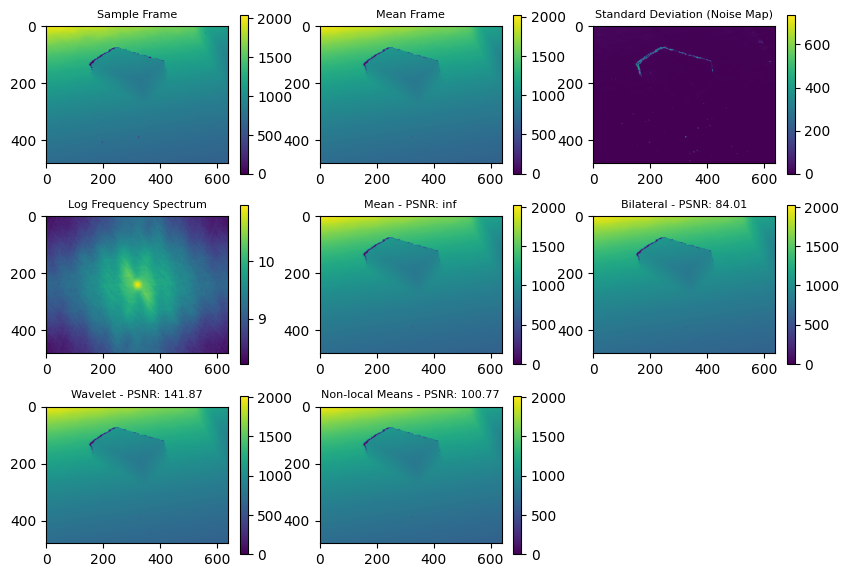

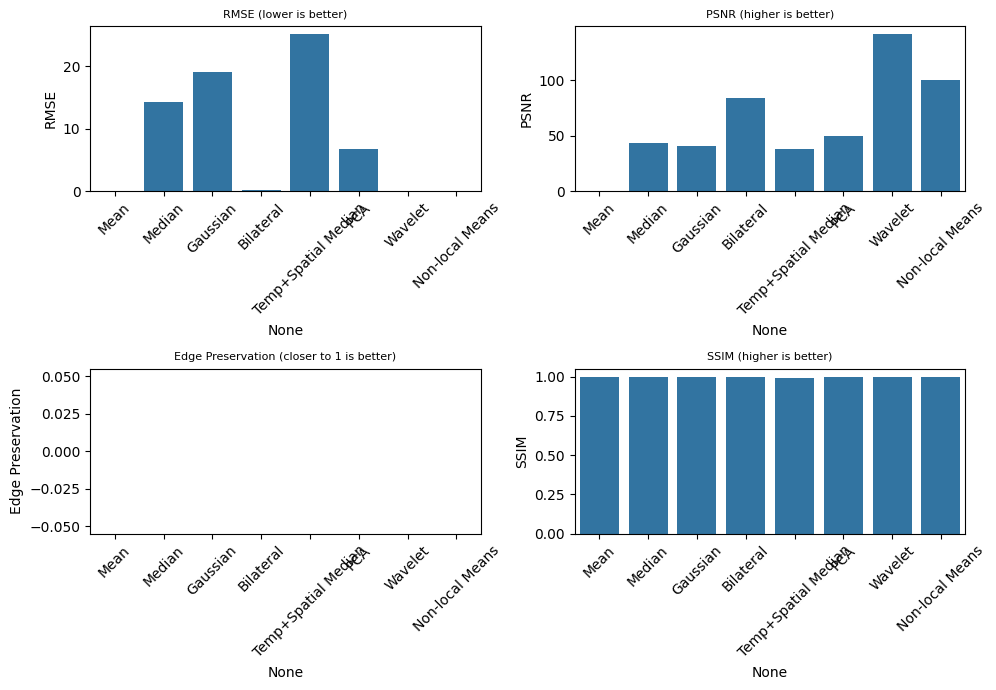

In [31]:
# Run the analysis
mean_frame, std_frame, freq_spectrum, denoising_results, metrics, best_method = analyze_depth_data_noise(depths)

# Display metrics as a pandas DataFrame
display(pd.DataFrame(metrics).T.sort_values('PSNR', ascending=False))

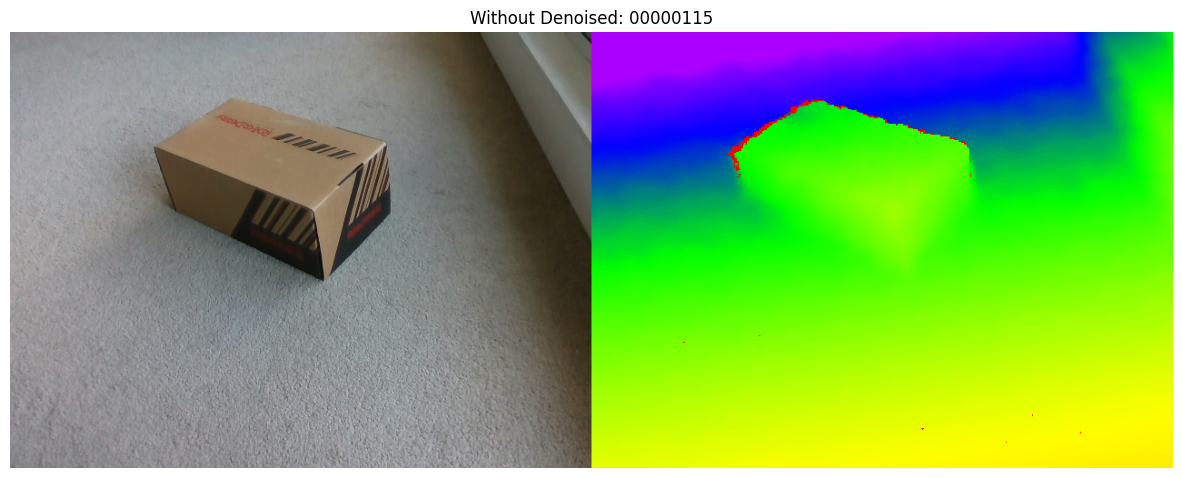

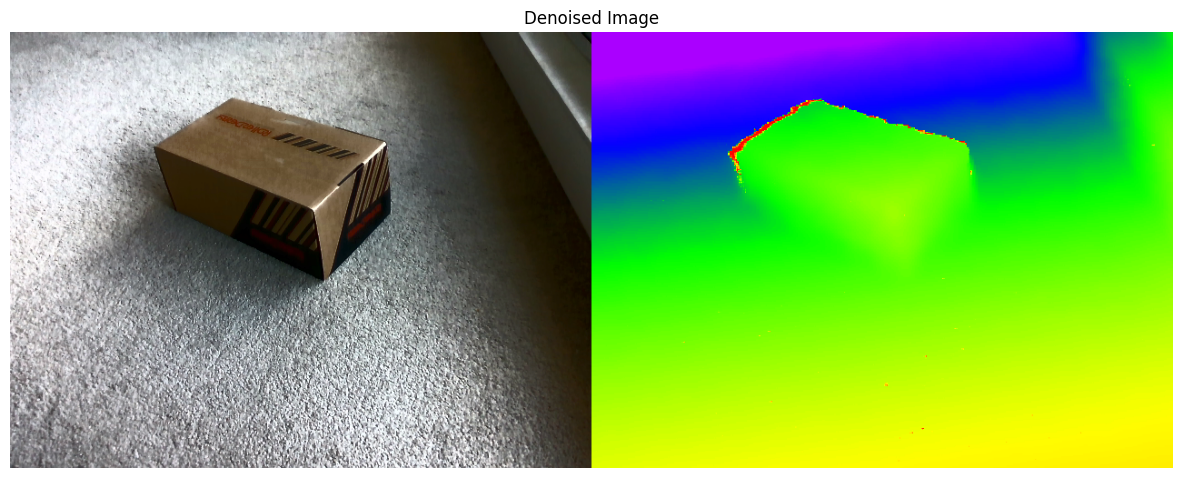

In [33]:
imshow(f"Without Denoised: {sample_index:08}", images[sample_index], depths[sample_index])
imshow("Denoised Image", enhance_single_frame(images[sample_index]), np.mean(depths, axis=0))